In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from IDX import IDX
from vn_config import vn_config

In [2]:
cd ../..

D:\Lyft


In [3]:
import os
result = [os.path.join(dp, f) for dp, dn, filenames in os.walk(vn_config["cached_data_path"]) for f in filenames if os.path.splitext(f)[1] == '.npz']

In [4]:
vn_config["cached_data_path"]

'pre_render_h01248_XXL\\validate\\'

In [5]:
train_npz = np.load(result[-1], allow_pickle=True)

In [6]:
df = pd.DataFrame(train_npz["X"])

In [7]:
pwd

'D:\\Lyft'

## Visualizing the graph node-wise
Each node contains 2 pairs of coorinates $(x, y), (x_{previous}, y_{previous})$. This graph consists of $N$ small lines ($N$ = number of nodes) where each of these lines $l_i$ connects $(x^i, y^i), (x_{previous}^i, y_{previous}^i)$

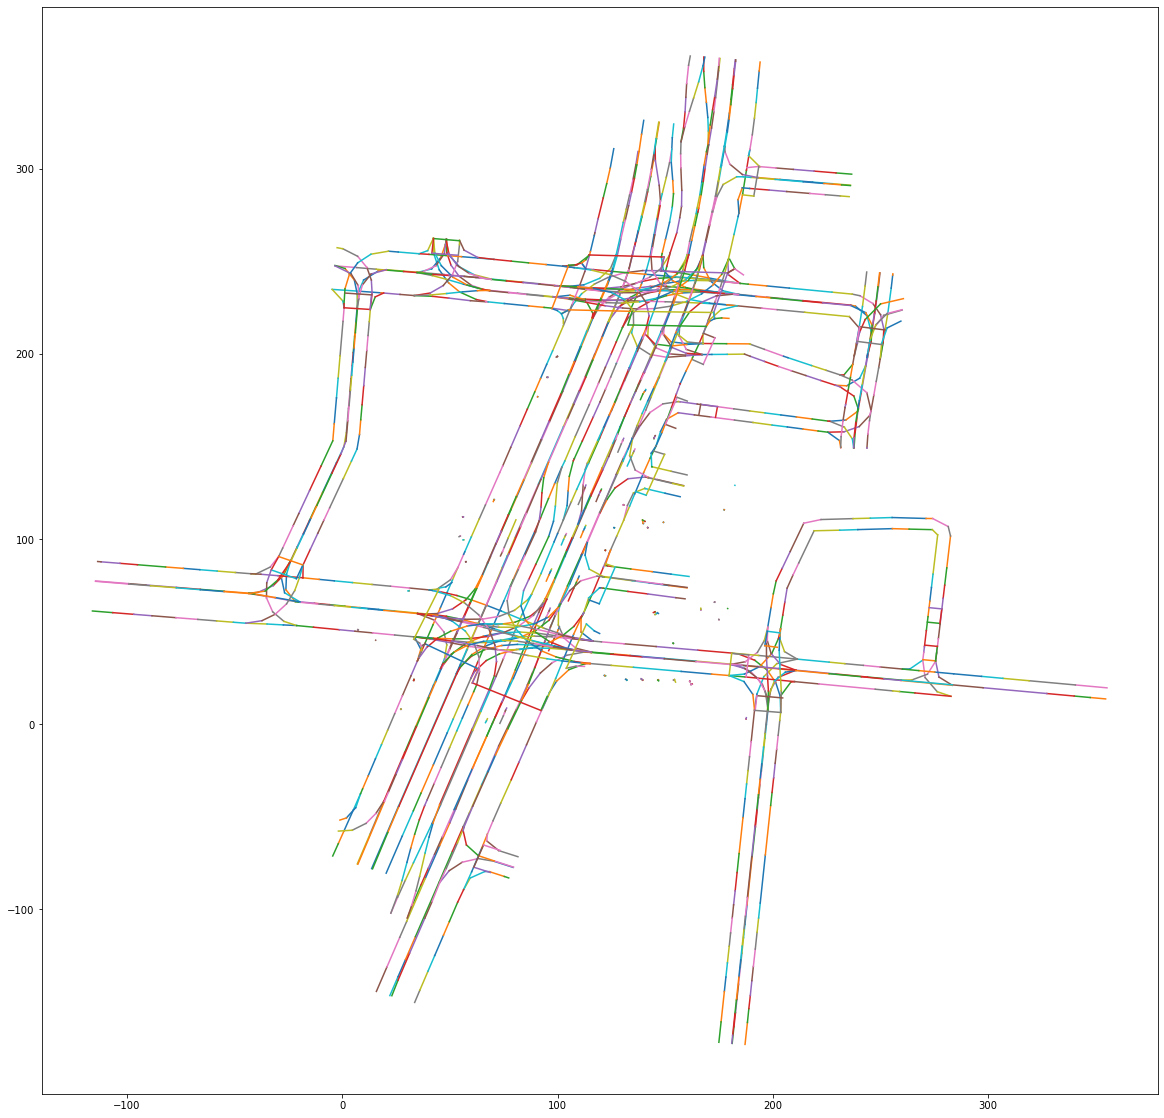

In [8]:
z = train_npz["X"][:, :4]
plt.figure(figsize = (20,20))
for i in range(z.shape[0]):
    j = z[i].reshape(-1, 2)
    if np.linalg.norm(j[1,:]) == 0:
        continue
    plt.plot(j[:, 0], j[:, 1], "-")

## Visualizing the graph line-wise
Here we give the same color for all nodes in same polyline. Thus we can see that seemingly one polyline consists of two or more lines, and sometimes lines intersect. It must be a confusing factor for the model.

(2861, 13)

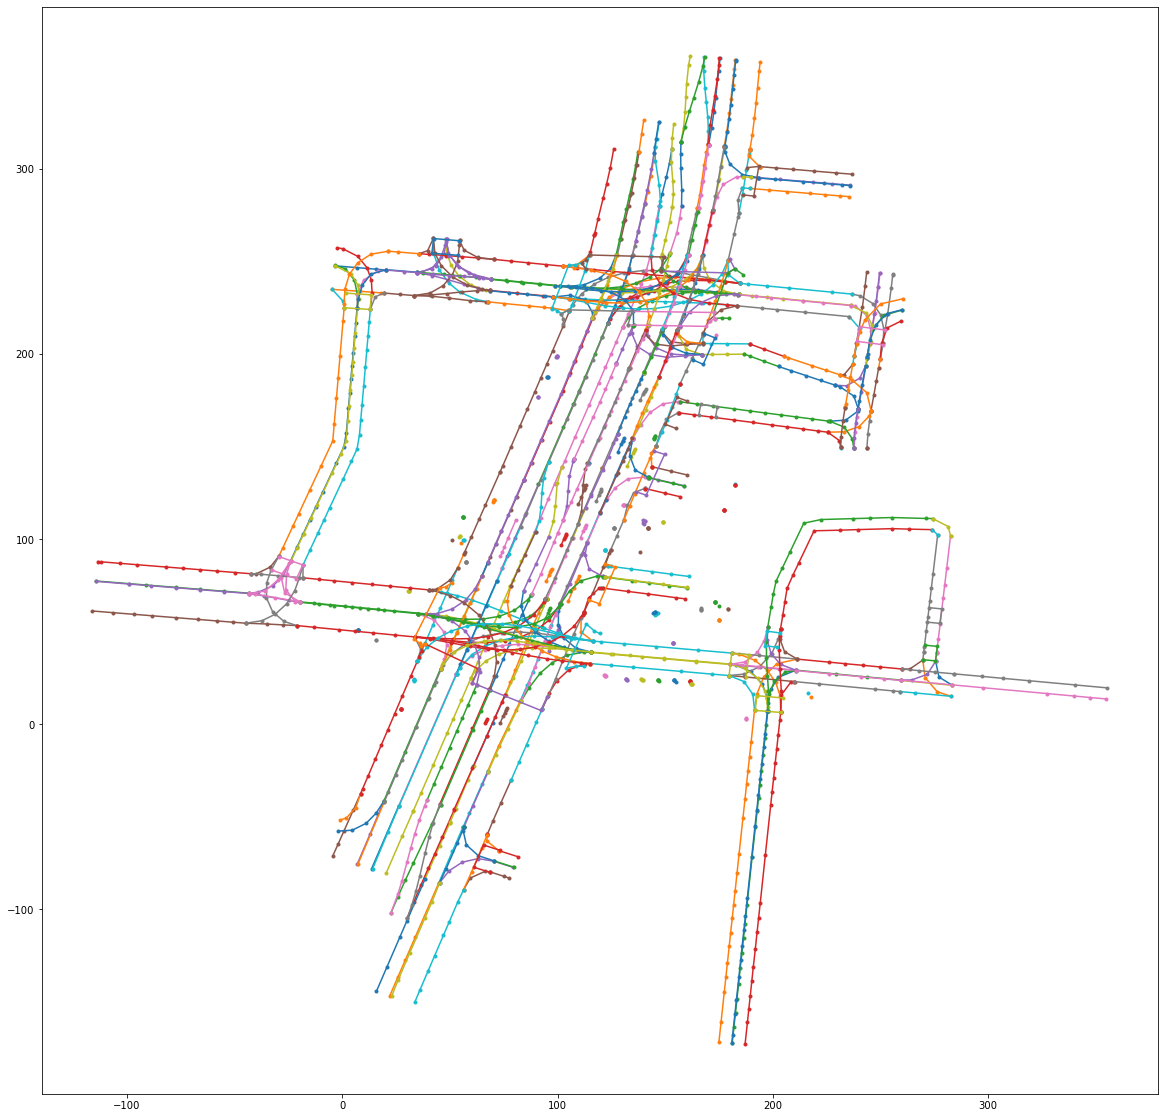

In [11]:
plt.figure(figsize = (20,20))
for pid, pdf in df.groupby(IDX["pindex"]):
    color = "gray"
#     if pid in ego_idx_np:# == ego_idx_np[batch]:
#         color = "green"
#         plt.plot(pdf[0], pdf[1], color = color, linewidth=4)
#         print(pid)
#         continue
    if pdf.iloc[0, IDX["ego"]] == 1:
        color = "lawngreen"
    if pdf.iloc[0, IDX["default"]] == 1:
        color = "black"
    if pdf.iloc[0, IDX["yellow"]] == 1:
        color = "yellow"
    if pdf.iloc[0, IDX["red"]] == 1:
        color = "red"
    if pdf.iloc[0, IDX["green"]] == 1:
        color = "palegreen"
    if pdf.iloc[0, IDX["crosswalk"]] == 1:
        color = "orange"
    if pdf.iloc[0, IDX["other"]] == 1:
        color = "blue"
    plt.plot(pdf[0], pdf[1], "-o", markersize = 3)
# plt.xlim([0,224])
# plt.ylim([0,224])

df.shape

## Visualizing the graph

(2861, 13)

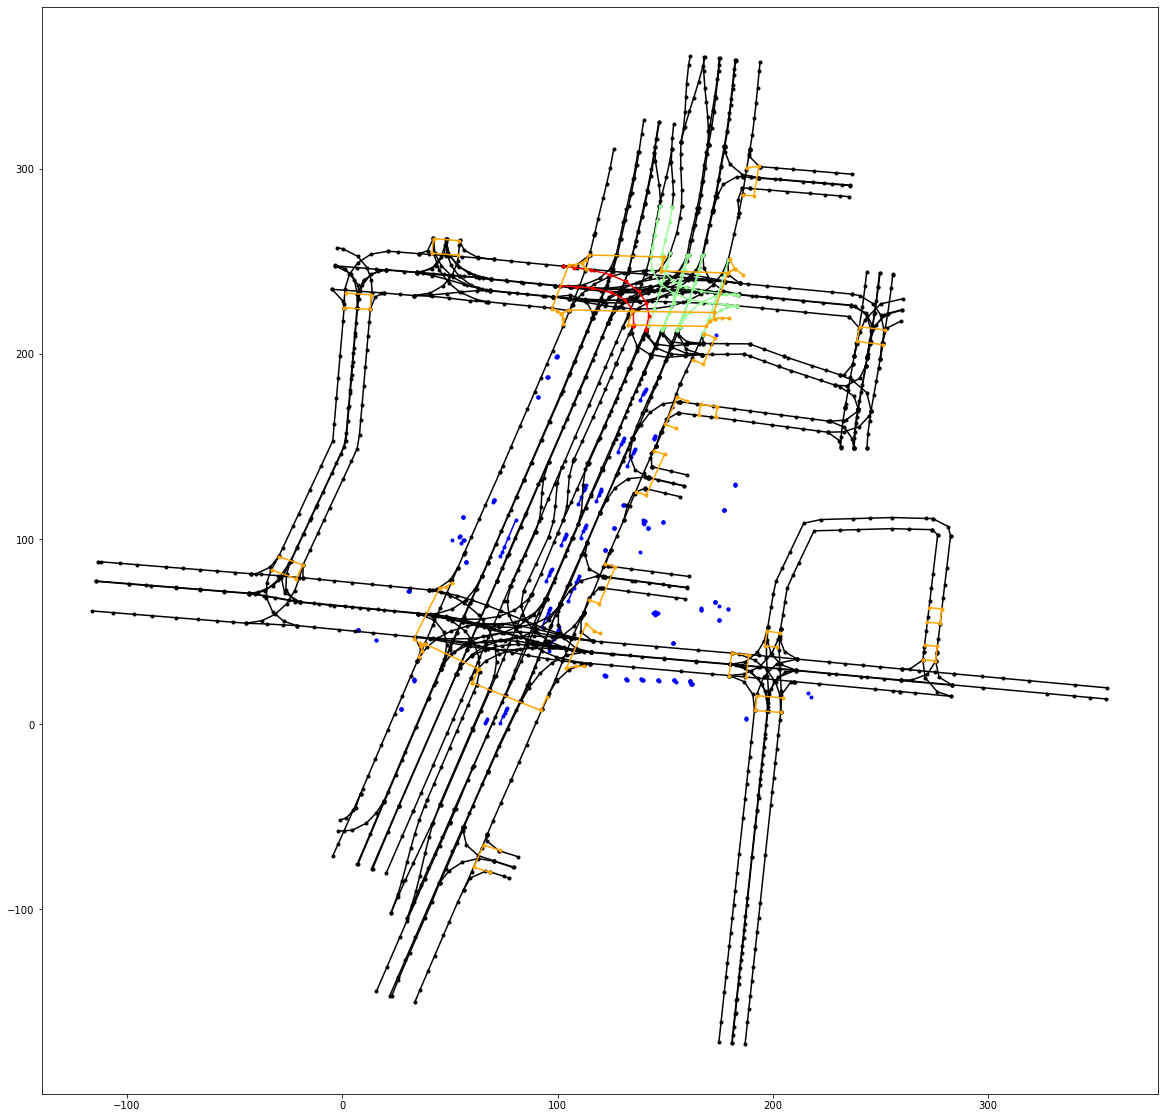

In [12]:
plt.figure(figsize = (20,20))
for pid, pdf in df.groupby(IDX["pindex"]):
    color = "gray"
#     if pid in ego_idx_np:# == ego_idx_np[batch]:
#         color = "green"
#         plt.plot(pdf[0], pdf[1], color = color, linewidth=4)
#         print(pid)
#         continue
    if pdf.iloc[0, IDX["ego"]] == 1:
        color = "lawngreen"
    if pdf.iloc[0, IDX["default"]] == 1:
        color = "black"
    if pdf.iloc[0, IDX["yellow"]] == 1:
        color = "yellow"
    if pdf.iloc[0, IDX["red"]] == 1:
        color = "red"
    if pdf.iloc[0, IDX["green"]] == 1:
        color = "palegreen"
    if pdf.iloc[0, IDX["crosswalk"]] == 1:
        color = "orange"
    if pdf.iloc[0, IDX["other"]] == 1:
        color = "blue"
    plt.plot(pdf[0], pdf[1], "-o", markersize = 3, color = color)
# plt.xlim([0,224])
# plt.ylim([0,224])

df.shape

In [25]:
pred.shape

torch.Size([48, 3, 50, 2])

In [27]:
from typing import Dict
from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import numba
import torch
from torch import nn, optim, Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch_scatter import scatter_max, scatter_min, scatter_mean
from torch_geometric.data import Data, DataLoader#, DataListLoader
from tqdm import tqdm
import pandas as pd
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from prettytable import PrettyTable
from pathlib import Path
import os
import requests
import random
from sklearn import preprocessing

from loss import pytorch_neg_multi_log_likelihood_batch
from dataset import VNDataSet
from utils import draw, mkdir
from vectornet import SubGraph, GlobalGraph
from IDX import IDX
from vn_config import vn_config

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

        
@numba.njit()
def _genkey(idx, batch):
    res = 0.
    res = batch * batch.shape[0] + idx
    return res


def genkey(idx, batch):
    le = preprocessing.LabelEncoder()
    res = _genkey(idx, batch)
    res = le.fit_transform(res)
    return res


inp_shape = len(IDX) - 1


class VN(nn.Module):
    def __init__(self):
        super(VN, self).__init__()

        self.sg1 = SubGraph(inp_shape, vn_config["hidden_dim"])
        self.sg2 = SubGraph(2*vn_config["hidden_dim"], vn_config["hidden_dim"])
        self.sg3 = SubGraph(2*vn_config["hidden_dim"], vn_config["hidden_dim"])
        
        self.gg  = GlobalGraph(2*vn_config["hidden_dim"], 128)
        self.decode = nn.Sequential(
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 303),
#             nn.BatchNorm1d(200),
#             nn.ReLU(),
#             nn.Linear(200, 303),
        )

    def forward(self, x, global_l, batches, ego_idx, l):
        sg1_res = self.sg1(      x, global_l)
        sg2_res = self.sg2(sg1_res, global_l)
        sg3_res = self.sg3(sg2_res, global_l)
        
        polylines_embedings = scatter_max(sg3_res, global_l, dim = 0)[0]
        polylines_batches   = scatter_mean(batches, global_l).long()
        
        gg_res, attn  = self.gg(polylines_embedings, polylines_batches, ego_idx)
        out = self.decode(gg_res)
        
        return out, attn
    
    
def build_model(cfg: Dict) -> torch.nn.Module:
    return VN()


def forward(data, model, device, criterion, train_mode = True):

    data = data.to(device)

    target_availabilities = data.target_availabilities
    targets = data.target_positions
    matrix = data.world_to_image
    centroid = data.centroid[:,None,:].to(torch.float)
    
    outputs, attentions = model(data.x, data.gi, data.batch, data.ego_idx, data.i) #, data.edge_index, data.batch)
    
    bs,tl,_ = targets.shape
    assert tl == 50

    outputs.squeeze_(1)
    confidences, pred = outputs[:,:3], outputs[:,3:]
    pred = pred.view(bs, 3, tl, 2)
    assert confidences.shape == (bs, 3)
    confidences = torch.softmax(confidences, dim=1)

    loss = pytorch_neg_multi_log_likelihood_batch(targets, pred, confidences, target_availabilities)# - 0.001 * pairwise_distance(pred, target_availabilities)
    loss = torch.mean(loss)

    return loss, pred, confidences, attentions


# ===== INIT DATASET

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE=",device)

model = build_model({}).to(device)
# model.load_state_dict(torch.load("models/tmp_vn_35524_392.60818356704937.pth")["model_state_dict"])
model.to(device)
            
dataset = VNDataSet(vn_config["cached_data_path"])

loader = DataLoader(dataset, batch_size = vn_config["batch_size"], shuffle = True, num_workers = vn_config["num_workers"])

print("="*80)
print(len(loader))
print("="*80)

optimizer = optim.Adam(model.parameters(), lr=vn_config["init_lr"])

# checkpoint = torch.load("../models/bs240_45012_54.303861933652236.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.2)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose = True, factor=0.5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 2*len(loader), eta_min=0, last_epoch=-1)
criterion = None#nn.MSELoss(reduction="none")

# ==== TRAIN LOOP
tr_it = iter(loader)
data0 = next(tr_it)

data0.gi = torch.LongTensor(genkey(data0.i.cpu().detach().numpy(), data0.batch.cpu().detach().numpy()))

progress_bar = tqdm(range(len(loader)))
losses_train = []
step = -1
for iteration in progress_bar:
    step += 1
    
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(loader)
        data = next(tr_it)
    
    if step % 1000 == 0:
        model.eval()
        with torch.no_grad():
            loss, pred, confidences, attentions = forward(data0, model, device, criterion)
            draw(data0,attn = attentions,step = step,pred = pred)
        continue
    
    data.gi = torch.LongTensor(genkey(data.i.cpu().detach().numpy(), data.batch.cpu().detach().numpy()))

    model.train()
    torch.set_grad_enabled(True)
    optimizer.zero_grad()

    loss, pred, confidences, attentions = forward(data, model, device, criterion)

    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    if step % len(loader) == 1 and step > 0:
        pass
        torch.save({
            'epoch': step,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f"{vn_config['models_path']}/fast_{step}_{np.mean(losses_train[-len(loader):])}.pth")

    progress_bar.set_description(f"loss(avg): {np.mean(losses_train[-len(loader):])} max:{np.max(losses_train[-len(loader):])} min:{np.min(losses_train[-len(loader):])} std:{np.std(losses_train[-len(loader):])}")


DEVICE= cuda
20


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


AssertionError: 